Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0507 - val_loss: 0.0067
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0016 - val_

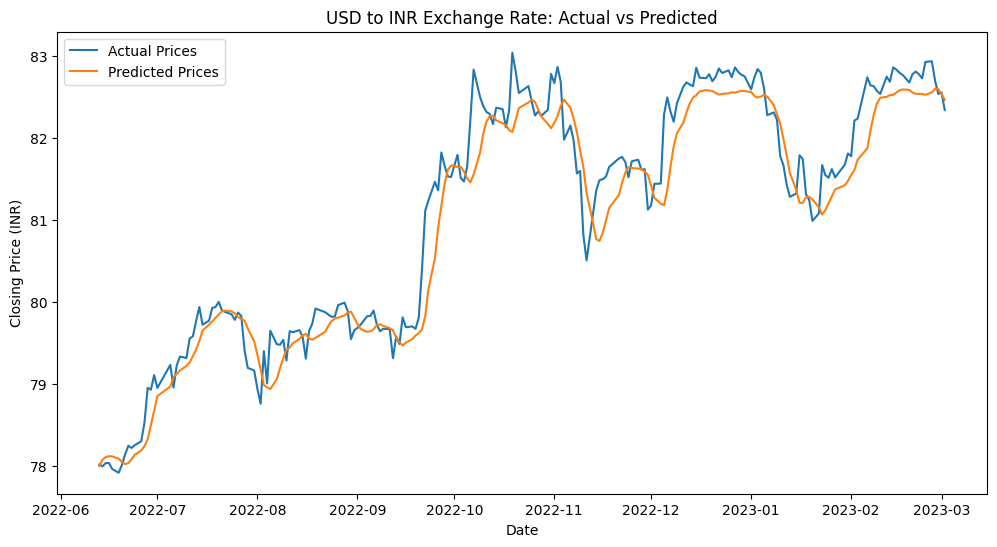

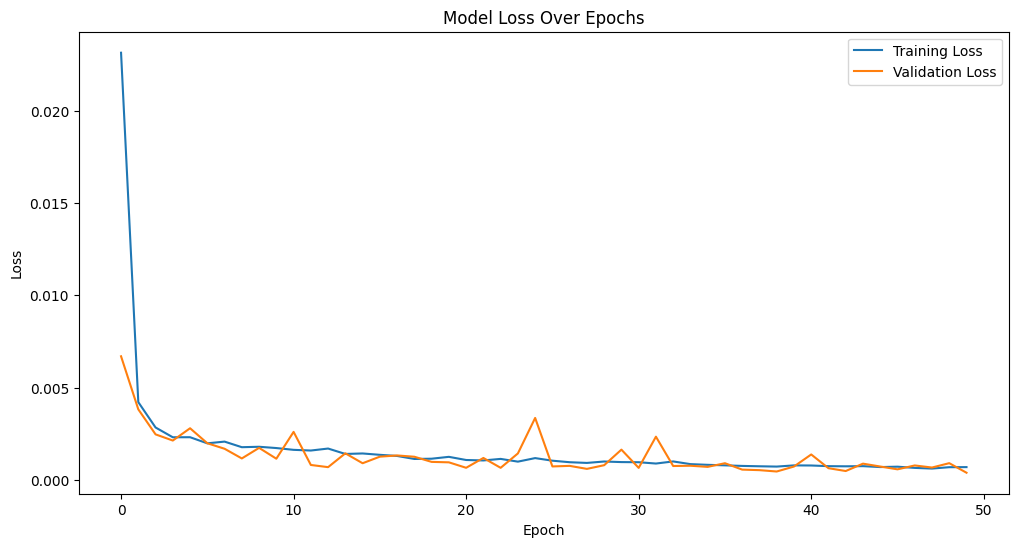

Tuned model saved as inr_seq_model.pkl


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

# Load the data
data = pd.read_csv('HistoricalData.csv')

# Parse dates and sort
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.sort_values('Date')

# Extract closing prices
closing_prices = data['Close/Last'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Use past 60 days to predict next day
X, y = create_sequences(scaled_prices, seq_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mae = np.mean(np.abs(predictions - y_test_actual))
rmse = np.sqrt(np.mean((predictions - y_test_actual) ** 2))
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data['Date'].iloc[-len(y_test_actual):], y_test_actual, label='Actual Prices')
plt.plot(data['Date'].iloc[-len(predictions):], predictions, label='Predicted Prices')
plt.title('USD to INR Exchange Rate: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price (INR)')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the tuned model to a pickle file for later use
with open('inr_seq_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Tuned model saved as inr_seq_model.pkl")


In [4]:
last_sequence = scaled_prices[-seq_length:]
next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
next_pred = scaler.inverse_transform(next_pred)
print(f'Predicted next day price: {next_pred[0][0]:.4f} INR')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted next day price: 82.1031 INR
